In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pylab
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import numpy as np
import random
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance
import os
import anndata as ad
from scipy import sparse
import scipy.cluster.hierarchy as sch

from matplotlib.colors import TwoSlopeNorm

import scanpy.external as sce

/group/testa/Users/davide.castaldi/Polaroid_publication_revisions/.local/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==56.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [2]:
sc.settings.set_figure_params(dpi=100, facecolor='white', dpi_save=500)
pylab.rcParams['figure.figsize'] = (9, 9)
protocol = "Kanton"
MappingDict = {"RGCs early 2":"vRG",
               "RGCs early 2":"vRG",
               "cortical neurons 1":"ExM",
               "IPs and early cortical neurons":"ExM",
               "ccRGCs":"cycling dorsal progenitors"}

if not os.path.exists('./figures'):
    os.makedirs('./figures')

if not os.path.exists('./tables'):
    os.makedirs('./tables')


In [3]:
Linn = sc.read_h5ad("./outdir/Braun/BraunIngested.h5ad")
#Organoids = sc.read_h5ad("../Emas_way/polcaEmasWay.h5ad")
Organoids = sc.read_h5ad("./data/AllOrganoids.h5ad")
Organoids = Organoids[Organoids.obs["Protocol"] == protocol]

In [4]:


Organoids = Organoids[:,Organoids.var_names.intersection(Linn.var_names)]
Linn = Linn[:,Organoids.var_names.intersection(Linn.var_names)]

In [5]:
# Subset linn
Linn = Linn[Linn.obs["PoliudakisIngestedAnno"].isin(["ExM","PgG2M","PgS","vRG"])]
Linn.obs["PoliudakisIngestedAnno"] = Linn.obs["PoliudakisIngestedAnno"].replace(["PgG2M","PgS"], "Cycling")

<ipython-input-5-68c00e5bbe68>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Linn.obs["PoliudakisIngestedAnno"] = Linn.obs["PoliudakisIngestedAnno"].replace(["PgG2M","PgS"], "Cycling")


In [6]:
# Subset orgs
Organoids = Organoids[Organoids.obs.OriginAnnotation.isin(list(MappingDict.keys()))]
Organoids

View of AnnData object with n_obs × n_vars = 5374 × 21219
    obs: 'sample', 'Protocol', 'OriginAnnotation'

In [7]:
Linn.obs["AggrRegion_Age"] = Linn.obs["AggrRegion"].astype(str) + "_" + Linn.obs["Age"].astype(str)
sc.pp.normalize_total(Linn, exclude_highly_expressed=True, target_sum=20000)

# Additional Processing

In [8]:
# AVG counts orgs

Organoids.obs["GroupFactor"] = Organoids.obs["OriginAnnotation"].astype(str)
OrganoidsPbulk = pd.concat([Organoids[Organoids.obs["GroupFactor"] == i ].to_df().T.mean(axis = 1).to_frame(name=i) for i in Organoids.obs["GroupFactor"].unique().tolist()], axis = 1)


<ipython-input-8-96db88d712ef>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Organoids.obs["GroupFactor"] = Organoids.obs["OriginAnnotation"].astype(str)


# Linn

In [9]:
pd.crosstab(Linn.obs["AggrRegion"],Linn.obs["Age"] )

Age,8.5,11.5,12.0,14.0
AggrRegion,,,,
Forebrain,4577,22100,17424,15631
Hindbrain,16003,4948,5273,1765
Midbrain,7439,2832,1120,1394


In [10]:
Linn.obs["GroupFactor"] = Linn.obs["AggrRegion_Age"].astype(str) + "_" + Linn.obs["PoliudakisIngestedAnno"].astype(str)


In [11]:
pd.crosstab(Linn.obs["AggrRegion_Age"],Linn.obs["PoliudakisIngestedAnno"] )

PoliudakisIngestedAnno,ExM,Cycling,vRG
AggrRegion_Age,,,
Forebrain_11.5,8293,12100,1707
Forebrain_12.0,6454,9838,1132
Forebrain_14.0,5351,9412,868
Forebrain_8.5,1331,2704,542
Hindbrain_11.5,2835,1074,1039
Hindbrain_12.0,3884,1312,77
Hindbrain_14.0,572,1135,58
Hindbrain_8.5,13736,1201,1066
Midbrain_11.5,1645,692,495


In [12]:
# AVG counts Linn
Linn.obs["GroupFactor"] = Linn.obs["AggrRegion_Age"].astype(str) + "_" + Linn.obs["PoliudakisIngestedAnno"].astype(str)
#Linn.obs["GroupFactor"] =  Linn.obs["AggrRegion"].astype(str) + "_" + Linn.obs["PoliudakisIngestedAnno"].astype(str)

LinnPbulk = pd.concat([Linn[Linn.obs["GroupFactor"] == i ].to_df().T.mean(axis = 1).to_frame(name=i) for i in Linn.obs["GroupFactor"].unique().tolist()], axis = 1)


In [13]:
LinnPbulk

,Hindbrain_8.5_ExM,Hindbrain_8.5_Cycling,Forebrain_8.5_ExM,Hindbrain_12.0_ExM,Midbrain_12.0_ExM,Forebrain_12.0_ExM,Forebrain_12.0_Cycling,Hindbrain_11.5_ExM,Hindbrain_11.5_Cycling,Forebrain_11.5_ExM,...,Forebrain_8.5_Cycling,Forebrain_14.0_vRG,Hindbrain_12.0_Cycling,Hindbrain_12.0_vRG,Midbrain_12.0_vRG,Midbrain_14.0_vRG,Hindbrain_14.0_vRG,Midbrain_8.5_Cycling,Midbrain_8.5_vRG,Midbrain_8.5_ExM
FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM87B,0.000000,0.017636,0.001519,0.002972,0.026749,0.002761,0.001609,0.003795,0.015066,0.001039,...,0.000935,0.026095,0.030963,0.200754,0.005230,0.068096,0.012290,0.000513,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC004556.1,0.026493,0.018879,0.032117,0.000000,0.000000,0.000155,0.001549,0.001974,0.002512,0.002068,...,0.051712,0.002644,0.000000,0.000000,0.000000,0.000000,0.000000,0.049734,0.049633,0.027631
AC233755.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC233755.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC240274.1,1.186185,0.478708,0.907954,0.427423,0.221808,0.622638,0.606210,0.510746,0.432030,0.643720,...,1.010619,0.465198,0.367400,0.075331,0.188643,0.729069,0.650387,0.602067,0.599861,0.566883


In [14]:
#adata_bulkFB = adata_bulk[(adata_bulk.obs.Region == "b'Forebrain'")]

LinnPbulkAdata = sc.AnnData(LinnPbulk.T)
LinnPbulkAdata.obs["Group"] = LinnPbulkAdata.obs_names.astype("category")



In [15]:

sc.pp.log1p(LinnPbulkAdata)
sc.pp.highly_variable_genes(LinnPbulkAdata, n_top_genes=500)
sc.tl.pca(LinnPbulkAdata, use_highly_variable=True)
LinnPbulkAdata.obs



,Group
Hindbrain_8.5_ExM,Hindbrain_8.5_ExM
Hindbrain_8.5_Cycling,Hindbrain_8.5_Cycling
Forebrain_8.5_ExM,Forebrain_8.5_ExM
Hindbrain_12.0_ExM,Hindbrain_12.0_ExM
Midbrain_12.0_ExM,Midbrain_12.0_ExM
Forebrain_12.0_ExM,Forebrain_12.0_ExM
Forebrain_12.0_Cycling,Forebrain_12.0_Cycling
Hindbrain_11.5_ExM,Hindbrain_11.5_ExM
Hindbrain_11.5_Cycling,Hindbrain_11.5_Cycling
Forebrain_11.5_ExM,Forebrain_11.5_ExM


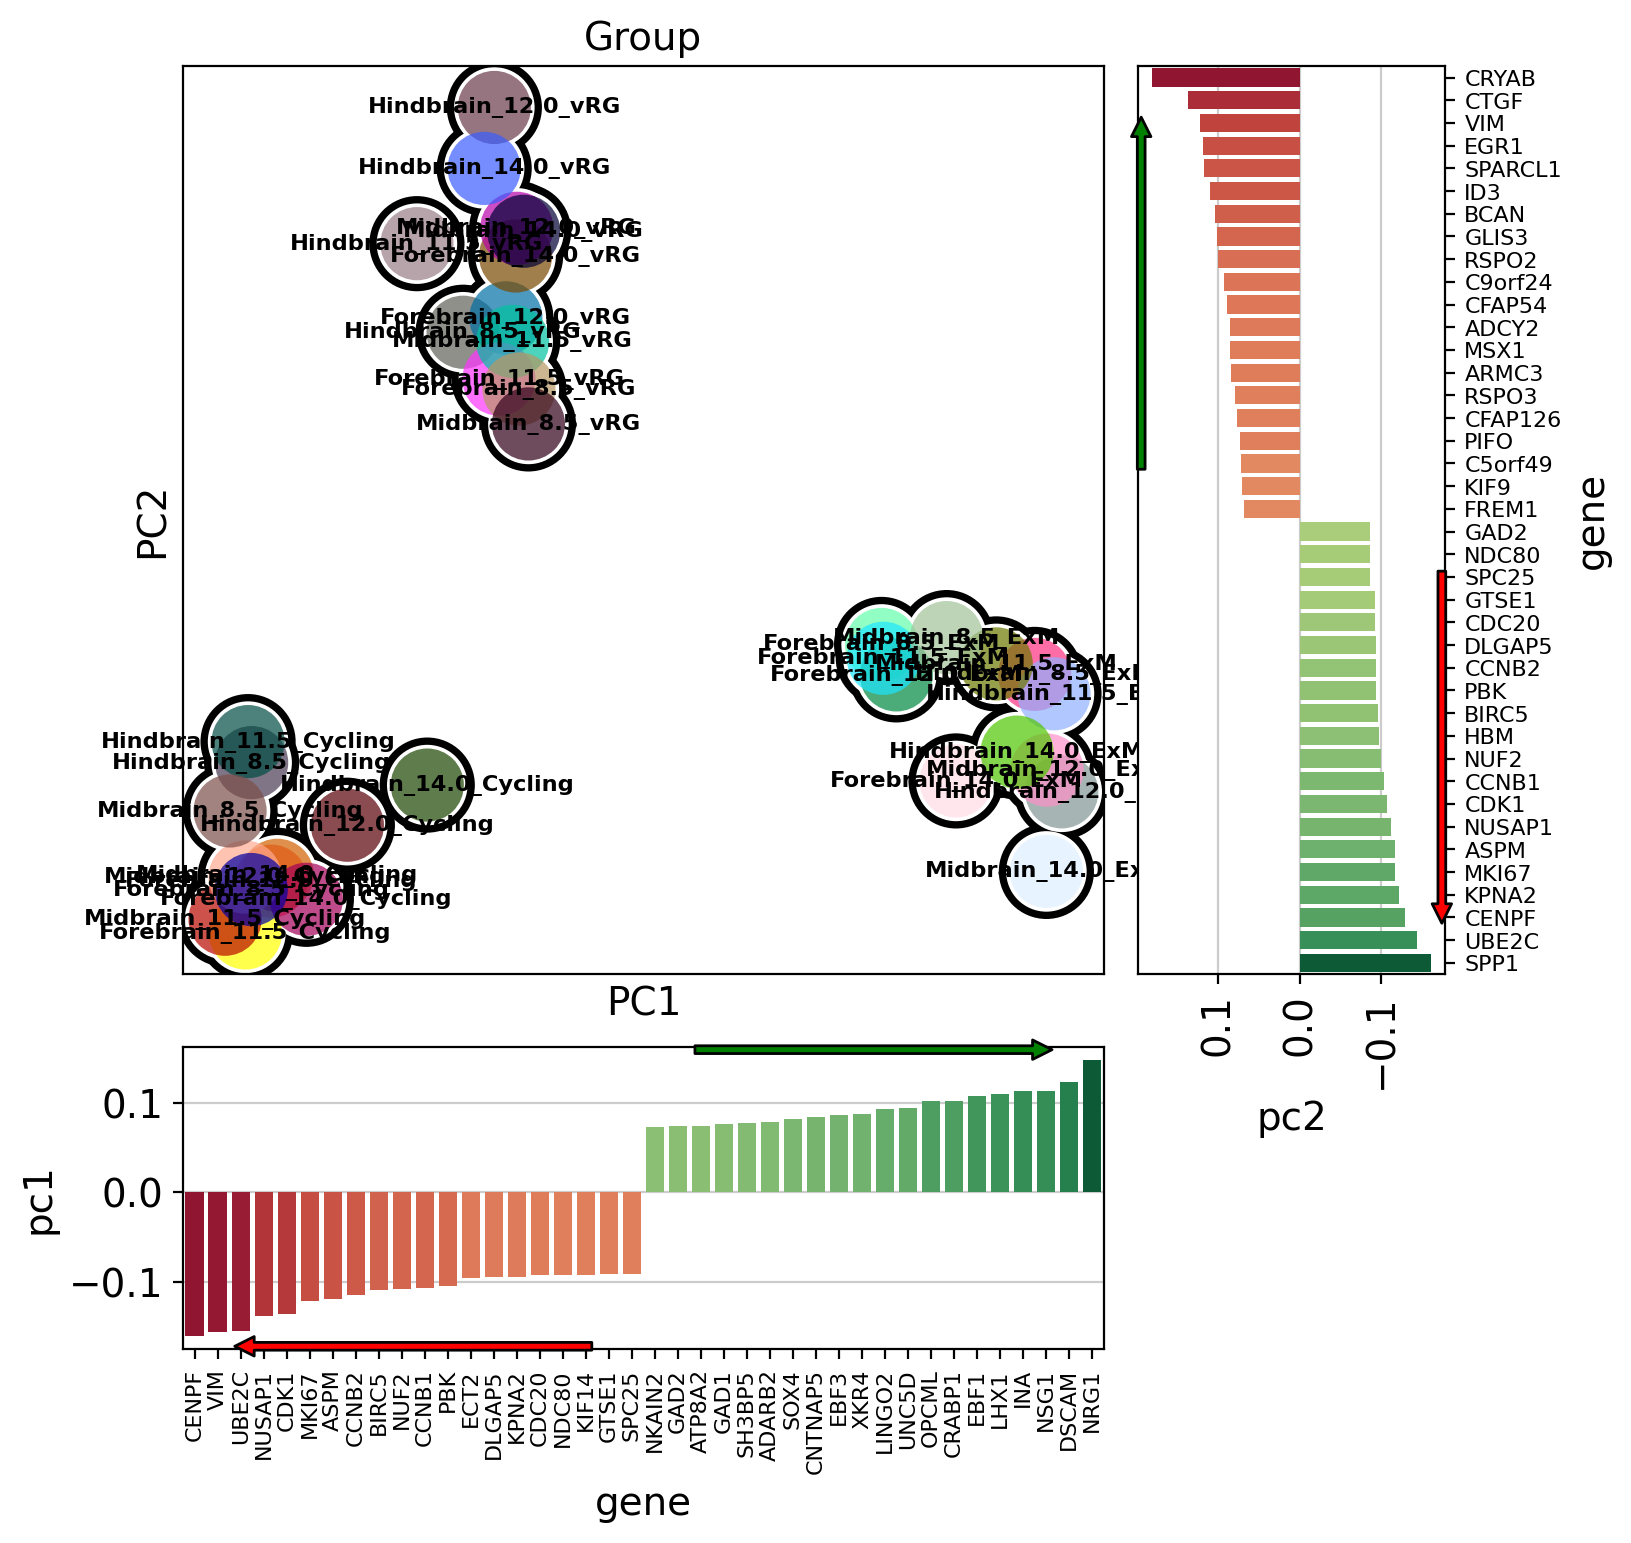

In [16]:
#if you want vector sc.settings._vector_friendly = False
vector=True
n=20
color="Group"
pcsToAssess = [0,1]
adataObj = LinnPbulkAdata


##################


dotsize = 100000/adataObj.shape[0]

pdDict = {}
if vector:
    sc.settings._vector_friendly = False
for pc in  pcsToAssess:
    TopPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adataObj.varm["PCs"][:,pc][TopPC_IDX], index = adataObj.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adataObj.varm["PCs"][:,pc][DownPC_IDX], index = adataObj.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == pcsToAssess[0]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == pcsToAssess[1]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (n/3.3333, n/3.3333)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adataObj, components=",".join([str(i+1) for i in pcsToAssess]), color=[color], 
                    ncols=1, add_outline=True, legend_loc="on data",size=dotsize,legend_fontsize="xx-small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)]]
sns.barplot(data=pdDict[pcsToAssess[0]], x="gene", y="pc"+str(pcsToAssess[0]+1), hue="pc"+str(pcsToAssess[0]+1),palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[1][0].get_legend().remove()


norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)]]
sns.barplot(data=pdDict[pcsToAssess[1]], x="pc"+str(pcsToAssess[1]+1), y="gene", hue="pc"+str(pcsToAssess[1]+1),palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].get_legend().remove()
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True

# TopMarkers

In [17]:
ngenes = 5
RegionOrder = ("Forebrain","Midbrain", "Hindbrain")
AllMarkers = {}


markersDF =pd.DataFrame()
for i in list(set([i.split("_")[1] for i in Linn.obs["GroupFactor"].unique().tolist()])):
	print("GW: {}".format(i))
	LinnPbulkTPT = LinnPbulk[[l for l in LinnPbulk.columns.tolist() if "_"+i+"_" in l]]
	UsablePairs = pd.Series([c.split("_")[-1] for c in set(LinnPbulkTPT.columns.tolist())]).value_counts()
	UsablePairs = UsablePairs[UsablePairs == 3].index.tolist()
	tptMarkers = []
	print("Found {} usable triplet for {}".format(UsablePairs,i))
	for p in UsablePairs:
		PairCol = LinnPbulkTPT[[c for c in LinnPbulkTPT.columns if p in c]]
		PairCol = PairCol[[RegionOrder[0]+"_"+i+"_"+p]+[RegionOrder[1]+"_"+i+"_"+p]+[RegionOrder[2]+"_"+i+"_"+p]]
		PairCol = PairCol+PairCol[PairCol != 0].min().min()
		for r in RegionOrder:
			PairColAggr = pd.concat([PairCol[PairCol.columns[PairCol.columns.str.contains(r)]], 
							PairCol[PairCol.columns[~PairCol.columns.str.contains(r)]].max(axis = 1).to_frame(name = "Other_{}_{}".format(i,p))]
							, axis = 1)
			markersDFLocal = pd.DataFrame({"Gene":(PairColAggr.iloc[:,0] / PairColAggr.iloc[:,1]).sort_values(ascending=False).head(ngenes).index.tolist(),
								"FC" : (PairColAggr.iloc[:,0] / PairColAggr.iloc[:,1]).sort_values(ascending=False).head(ngenes).tolist(),
								"Identity":r,"GW":i,"Celltype":p,
								"Contrast":"__VS__".join([PairColAggr.columns.tolist()[0]]+[PairColAggr.columns.tolist()[1]])})
			markersDF = pd.concat([markersDF, markersDFLocal])


GW: 14.0
Found ['Cycling', 'ExM', 'vRG'] usable triplet for 14.0
GW: 8.5
Found ['Cycling', 'ExM', 'vRG'] usable triplet for 8.5
GW: 12.0
Found ['Cycling', 'ExM', 'vRG'] usable triplet for 12.0
GW: 11.5
Found ['Cycling', 'ExM', 'vRG'] usable triplet for 11.5


# Transcriptional correlation

In [18]:

OverallCorr = pd.DataFrame()
for i in list(set([i.split("_")[1] for i in Linn.obs["GroupFactor"].unique().tolist()])):
#for i in ["14.0"]:
	for c in OrganoidsPbulk.columns.tolist():
		GeneSig = markersDF.loc[(markersDF["GW"] == i) & (markersDF["Celltype"] == MappingDict[c]),"Gene"].unique().tolist()
		LinnPbulkSS = LinnPbulk.loc[GeneSig, [l for l in LinnPbulk.columns.tolist() if "_"+i+"_" in l and MappingDict[c] in l ]]
		OrganoidsPbulkSS = OrganoidsPbulk.loc[GeneSig,c ].to_frame(name=c)
		LinnPbulkSS.columns = [i.split("_")[0] for i in LinnPbulkSS.columns.tolist()]
		combined = pd.concat([LinnPbulkSS,OrganoidsPbulkSS], axis = 1)
		correlationM = combined.corr(method = "spearman")
		correlationM = correlationM.drop(columns=c)
		correlationM = correlationM.loc[c]
		correlationM = correlationM.to_frame().T
		correlationM = correlationM.melt()
		correlationM["Age"] = i
		correlationM["leidenAnno"] = c
		correlationM = correlationM.rename(columns={"value":"Correlation","variable":"Reference"})
		correlationM["Reference"] =  MappingDict[c] + "_" +correlationM["Reference"]
		OverallCorr = pd.concat([OverallCorr,correlationM], ignore_index=True)


<ipython-input-19-8d81163765e0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDF["Age"] = plotDF["Age"].astype("float")
<ipython-input-19-8d81163765e0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDF["Age"] = plotDF["Age"].astype("float")
<ipython-input-19-8d81163765e0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

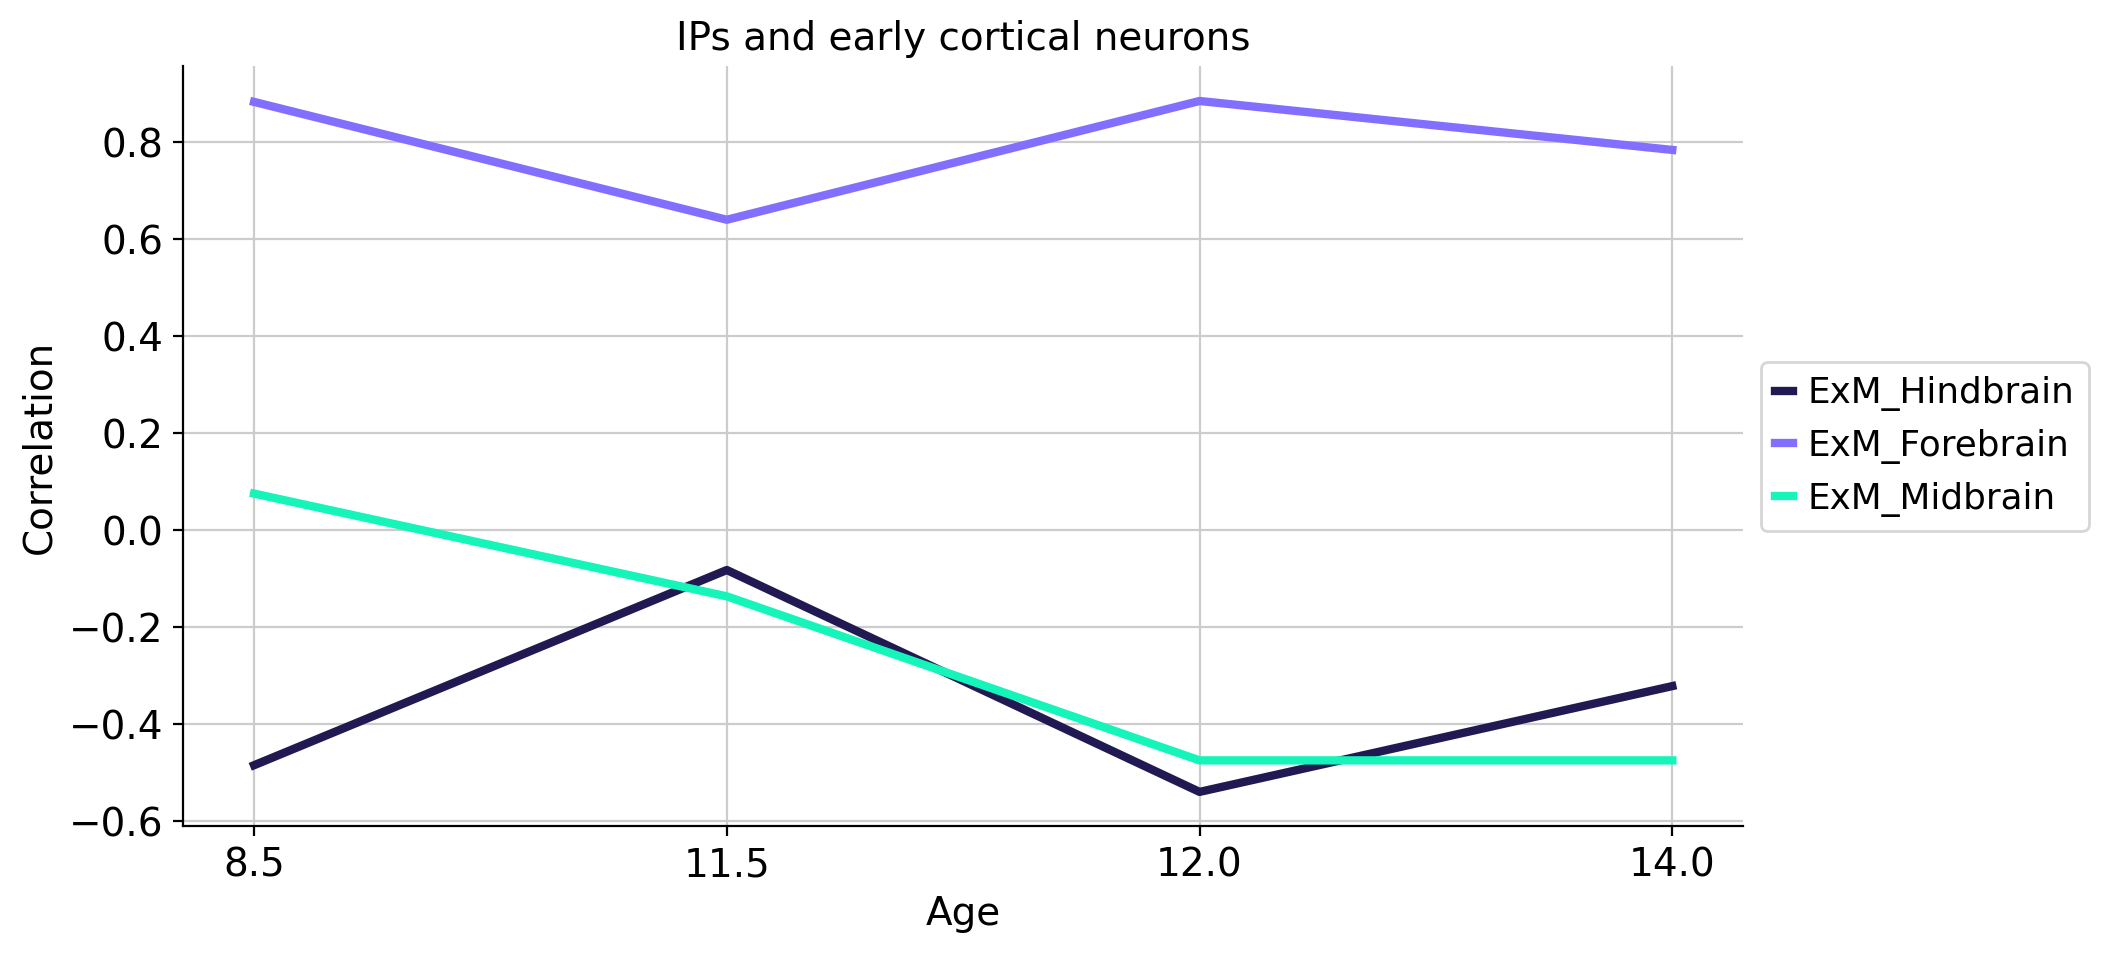

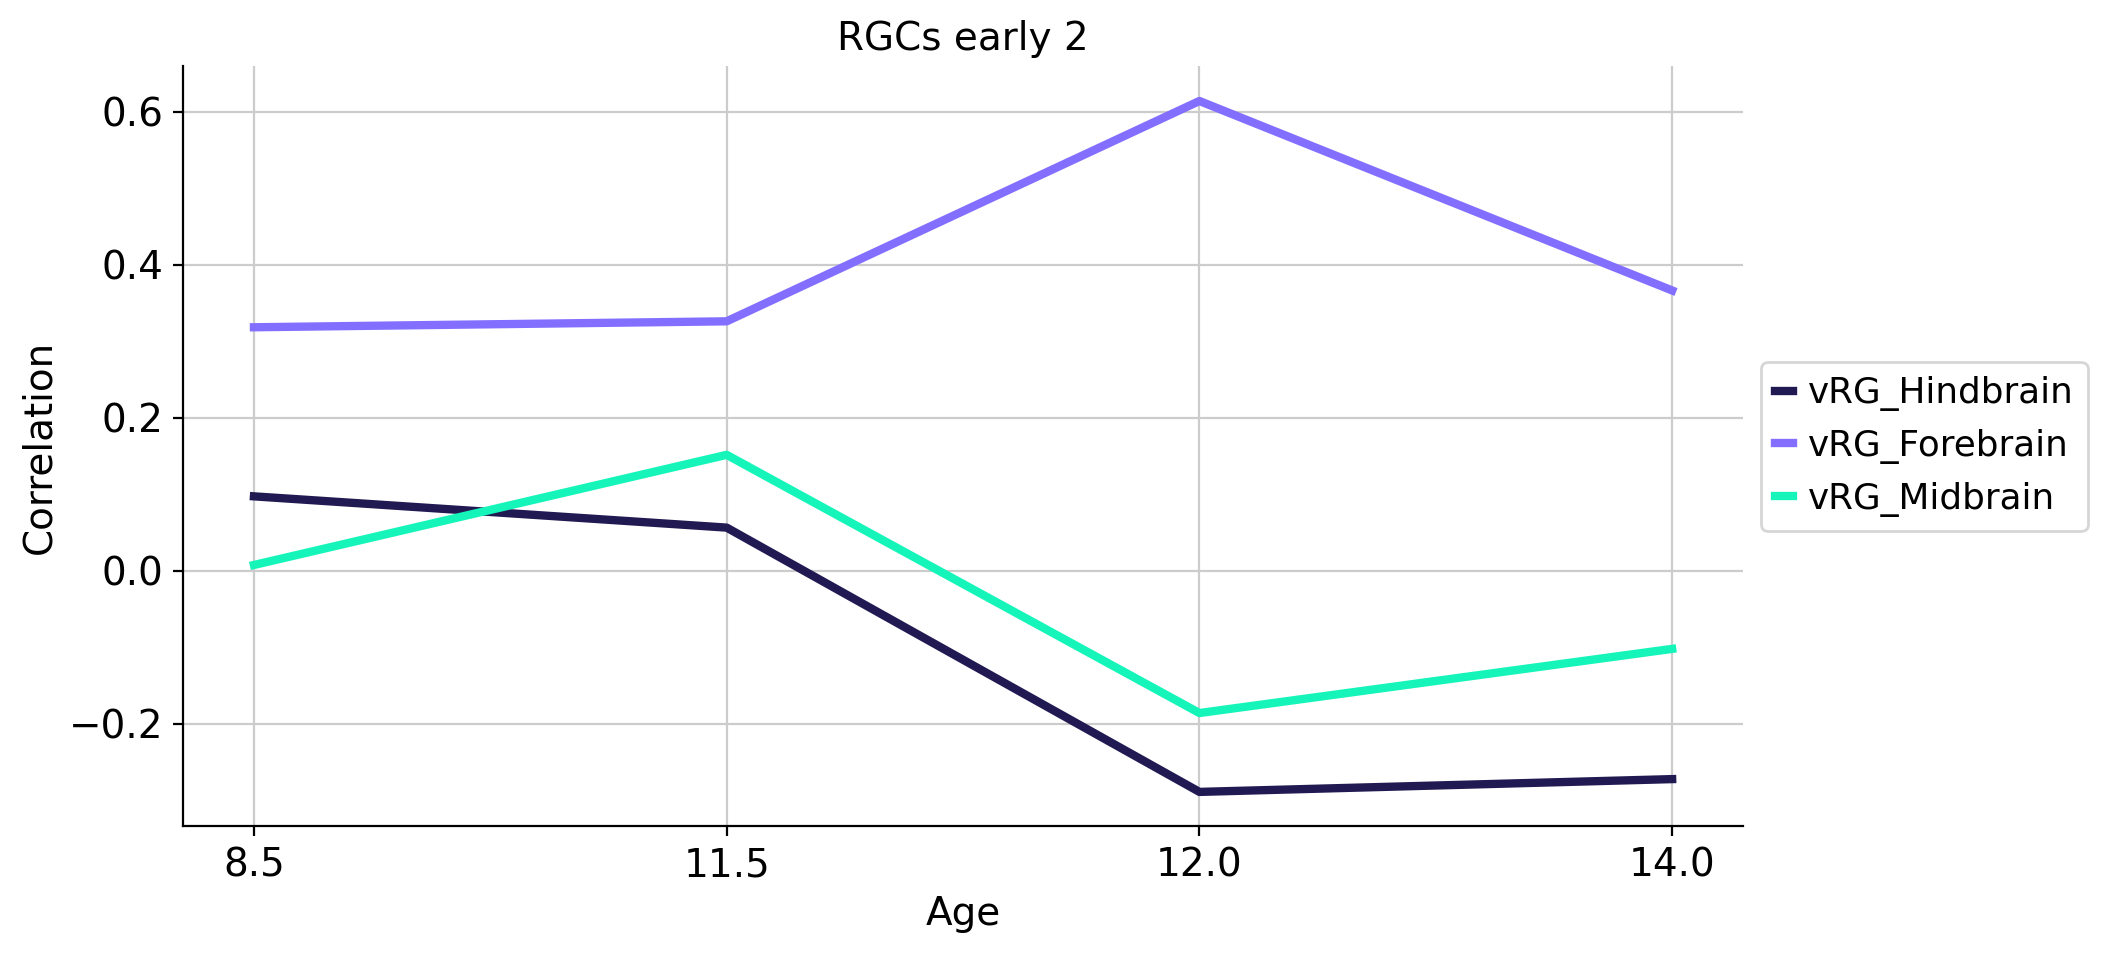

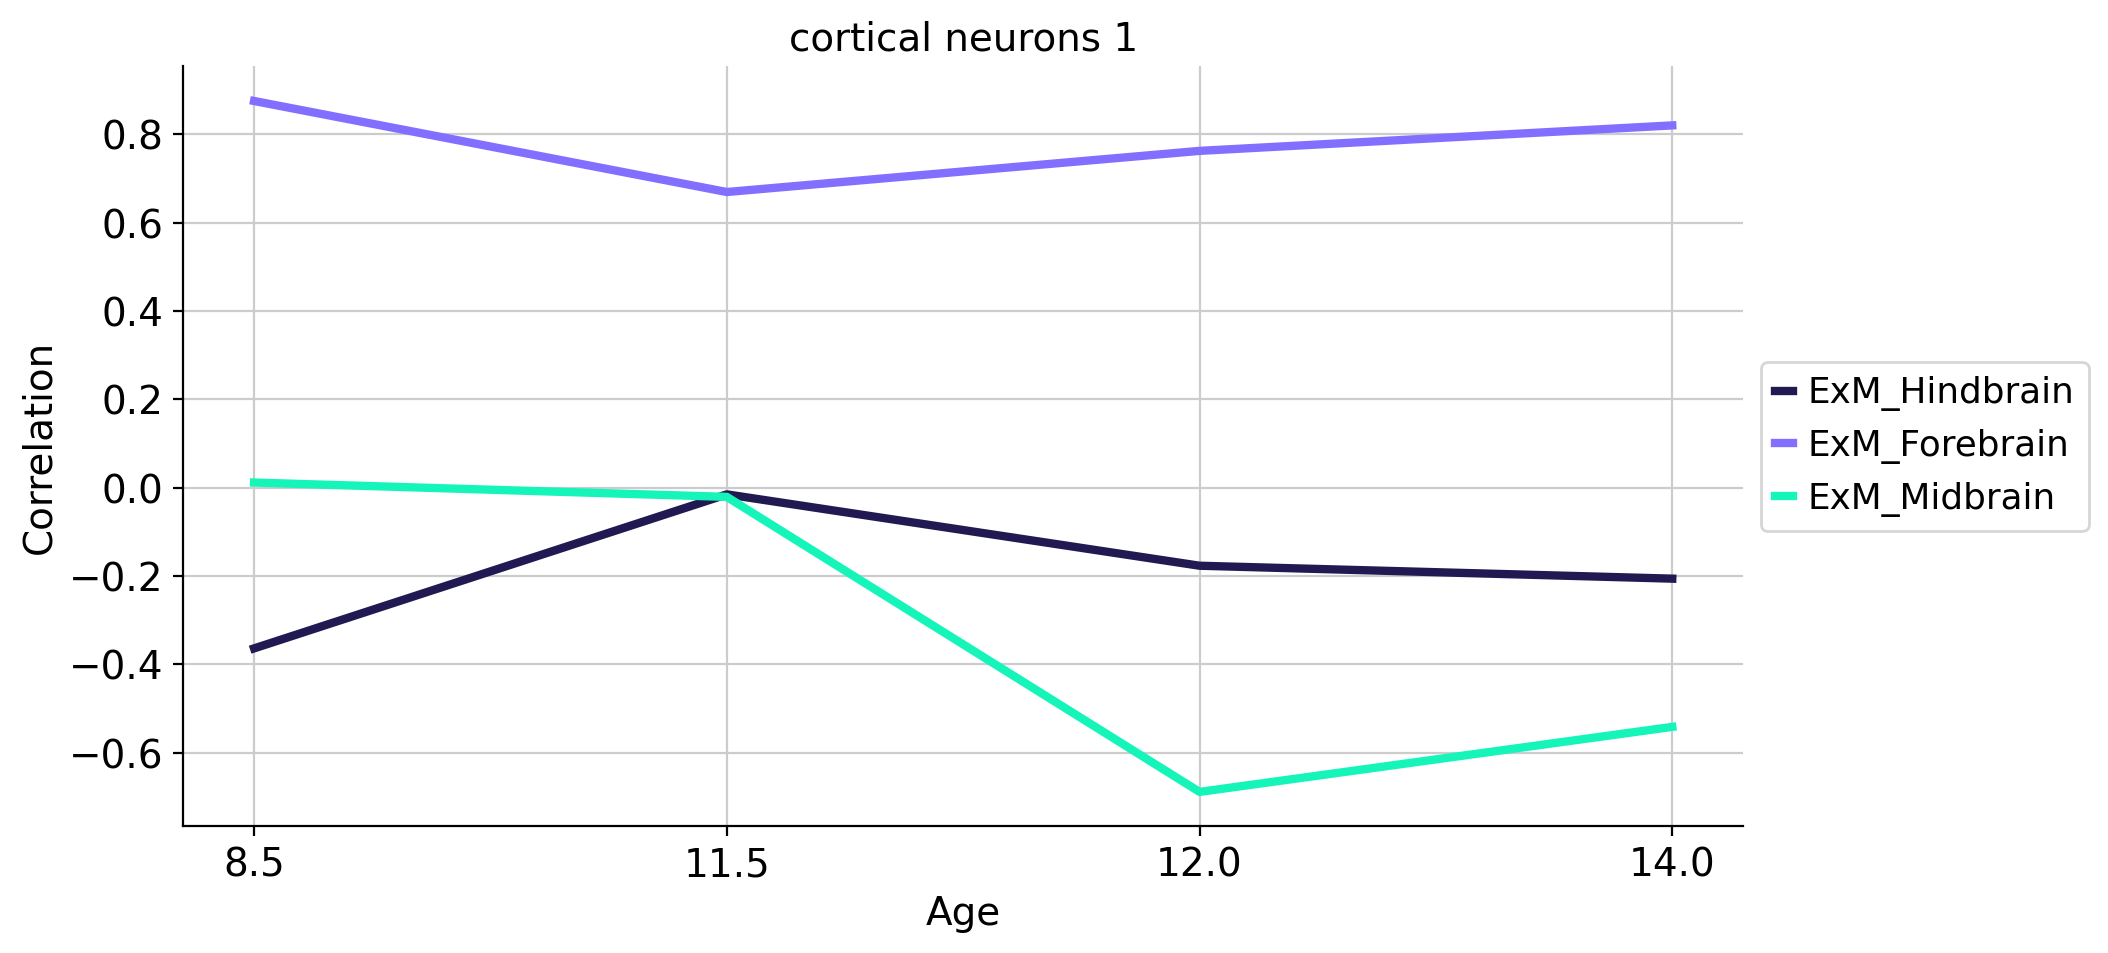

In [19]:
Basecols = {"Midbrain":"#15F5BA","Forebrain":"#836FFF","Hindbrain":"#211951"}

ColsDict = {}
for i in OverallCorr.Reference.unique().tolist():
	ColsDict[i] = Basecols[[k for k in list(Basecols.keys()) if k in i][0]]


sns.axes_style("white")

for i in OverallCorr["leidenAnno"].unique().tolist():
		plotDF = OverallCorr[OverallCorr["leidenAnno"] == i]
		plotDF["Age"] = plotDF["Age"].astype("float")
		plotDF = plotDF.sort_values("Age")
		plotDF["Age"] = plotDF.Age.astype(str)
		fig, ax = plt.subplots(figsize=(10,5))
		sns.lineplot(
			data=plotDF, x="Age", y="Correlation", hue="Reference", ax=ax, palette=ColsDict, linewidth = 3)
		ax.set_title(i)
		sns.despine()
		ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
		fig.show()
		fig.savefig("./figures/Kanton_Correlation_{}.svg".format(i), bbox_inches='tight')


In [22]:
OverallCorr

,Reference,Correlation,Age,leidenAnno
0,ExM_Midbrain,-0.474684,14.0,IPs and early cortical neurons
1,ExM_Forebrain,0.784373,14.0,IPs and early cortical neurons
2,ExM_Hindbrain,-0.321519,14.0,IPs and early cortical neurons
3,vRG_Forebrain,0.366397,14.0,RGCs early 2
4,vRG_Midbrain,-0.102150,14.0,RGCs early 2
5,vRG_Hindbrain,-0.272399,14.0,RGCs early 2
6,ExM_Midbrain,-0.541308,14.0,cortical neurons 1
7,ExM_Forebrain,0.820610,14.0,cortical neurons 1
8,ExM_Hindbrain,-0.205697,14.0,cortical neurons 1
9,ExM_Hindbrain,-0.484653,8.5,IPs and early cortical neurons


In [21]:
OverallCorr.to_excel("./tables/FigExtended7B.xlsx")

In [20]:
markersDF.sort_values("FC")

,Gene,FC,Identity,GW,Celltype,Contrast
4,SIDT1-AS1,24.868179,Midbrain,8.5,vRG,Midbrain_8.5_vRG__VS__Other_8.5_vRG
3,SHISA3,25.602474,Midbrain,8.5,vRG,Midbrain_8.5_vRG__VS__Other_8.5_vRG
2,MTUS2-AS2,26.283783,Midbrain,8.5,vRG,Midbrain_8.5_vRG__VS__Other_8.5_vRG
4,HES3,26.474089,Midbrain,8.5,Cycling,Midbrain_8.5_Cycling__VS__Other_8.5_Cycling
3,INSL3,28.335073,Midbrain,8.5,Cycling,Midbrain_8.5_Cycling__VS__Other_8.5_Cycling
...,...,...,...,...,...,...
1,EMX1,30387.078125,Forebrain,12.0,Cycling,Forebrain_12.0_Cycling__VS__Other_12.0_Cycling
0,LINC01551,31526.376953,Forebrain,14.0,Cycling,Forebrain_14.0_Cycling__VS__Other_14.0_Cycling
0,FOXG1,36071.003906,Forebrain,12.0,ExM,Forebrain_12.0_ExM__VS__Other_12.0_ExM
0,DLX1,41553.714844,Forebrain,11.5,Cycling,Forebrain_11.5_Cycling__VS__Other_11.5_Cycling
